<center>

# Julia言語を用いた精度保証付き数値計算の実践

### 高安亮紀（筑波大学）

#### 第5回 精度保証付き数値計算の実問題への応用研究集会 (NVR 2021)
#### 2021年11月28日(日)
</center>

## Why Julia?

- [Julia](https://julialang.org/)：新しいプログラミング言語でコンパイル型言語の高性能性と動的言語の俊敏性を組み合わせることに成功している
- （JITで比較的）**速い**、**安い**（オープンソース）、**美味い**（割と何でも簡単にできる）
- オープンソースのコミュニティが毎日色々なパッケージを開発していて、日々進化している
- 個人的に気に入っていることは、手軽にパッケージを組み合わせてやりたい事ができる点（賛否両論あり）


**注**　残念ながら、講演者はJuliaを語れるほど詳しくないので、言語の詳細は例えば以下の書籍等を参照いただきたい。

1. [Bogumił Kamiński、Przemysław Szufel著、中田秀基訳「Juliaプログラミングクックブック ―言語仕様からデータ分析、機械学習、数値計算まで」、オライリージャパン、2019](https://www.oreilly.co.jp/books/9784873118895/)
1. [進藤裕之、佐藤建太著「1から始める Juliaプログラミング」、コロナ社、2020](https://www.coronasha.co.jp/np/isbn/9784339029055/)
1. [石井一夫著「基礎から学ぶJulia ~基本文法からデータサイエンスまで」、SCC Books、2021](https://www.scc-kk.co.jp/scc-books/b-418.html)

## 精度保証付き数値計算にJulia?

精度保証付き数値計算のソフトウェアといったら…

- MATLAB with [INTLAB](https://www.tuhh.de/ti3/rump/intlab/)
- C++ with [kv](http://verifiedby.me/kv/)
- C++ with [CAPD](http://capd.ii.uj.edu.pl/)
- 他、[Languages for Interval Analysis](https://www.cs.utep.edu/interval-comp/intlang.html)や[Interval and Related Software](https://www.cs.utep.edu/interval-comp/intsoft.html)に一覧がある（随時更新されてるが、頻繁にサーバーが落ちる）

今回はJuliaにある[IntervalArithmetic.jl](https://juliaintervals.github.io/IntervalArithmetic.jl/latest/intro/)というパッケージを使って、精度保証付き数値計算を実現する方法を紹介する。これは講演者が学生さんたちと進めている、「[Juliaで精度保証付き数値計算](https://taklab-blog.blogspot.com/2021/01/rigorous-numerics-julia.html)」プロジェクトの報告プラスαである。（少々プロ向けにしたつもり）


### 「Juliaで精度保証付き数値計算」の目次

まず、「[Juliaで精度保証付き数値計算](https://taklab-blog.blogspot.com/2021/01/rigorous-numerics-julia.html)」プロジェクトでは、以下のような目次で精度保証付き数値計算の実装例を紹介している。

1. はじめに -間違える数値計算-（[nonrigorous_numerics.ipynb](https://www.risk.tsukuba.ac.jp/~takitoshi/tutorial/nonrigorous_numerics.html)）
1. 整数・浮動小数点数（[floating-point.ipynb](https://www.risk.tsukuba.ac.jp/~takitoshi/tutorial/floating-point.html)）
1. 丸め誤差・その他の誤差（[rounding-error.ipynb](https://www.risk.tsukuba.ac.jp/~takitoshi/tutorial/rounding-error.html)）
1. 区間演算 -精度保証付き数値計算の入り口-（[interval-arithmetic.ipynb](https://www.risk.tsukuba.ac.jp/~takitoshi/tutorial/interval-arithmetic.html)）
1. ベクトルの内積・行列ベクトル積・行列積の区間演算（[interval_dot-mul.ipynb](https://www.risk.tsukuba.ac.jp/~takitoshi/tutorial/interval_dot-mul.html)）
1. 線型方程式の解の精度保証付き数値計算（[verifylss.ipynb](https://www.risk.tsukuba.ac.jp/~takitoshi/tutorial/verifylss.html)）
1. 標準固有値問題の精度保証付き数値解法（[verifyalleig.ipynb](https://www.risk.tsukuba.ac.jp/~takitoshi/tutorial/verifyalleig.html)）
1. 高速フーリエ変換の精度保証（[verifyfft.ipynb](https://www.risk.tsukuba.ac.jp/~takitoshi/tutorial/verifyfft.html)）
1. 非線形方程式（[verifynlss.ipynb](https://www.risk.tsukuba.ac.jp/~takitoshi/tutorial/verifynlss.html)）
1. Newton-Kantorovich型定理 (radii-polynomial approach)（[Newton-Kantorovich.ipynb](https://www.risk.tsukuba.ac.jp/~takitoshi/tutorial/Newton-Kantorovich.html)）

これらは昨年度、学生さんとJuliaの使い方を勉強しながら実装したものである。今年度は

- フーリエ級数（計算機で表現する方法）
- 離散畳み込みの精度保証付き数値計算
- 常微分方程式の周期解の数値検証
- チェビシェフ級数、 etc.

という項目を追加予定。今日はこれらの一部をピックアップして紹介する。

## 計算機環境

今日の計算機環境は以下。

In [1]:
versioninfo()

Julia Version 1.6.3
Commit ae8452a9e0 (2021-09-23 17:34 UTC)
Platform Info:
  OS: macOS (x86_64-apple-darwin19.5.0)
  CPU: Apple M1
  WORD_SIZE: 64
  LIBM: libopenlibm
  LLVM: libLLVM-11.0.1 (ORCJIT, westmere)


In [2]:
using Pkg; Pkg.status("IntervalArithmetic")

      Status `~/.julia/environments/v1.6/Project.toml`
  [d1acc4aa] IntervalArithmetic v0.19.2


## 準備

精度保証付き数値計算を実行するために、Juliaで区間演算を使用する。IntervalArithmetic.jlパッケージを使うにはREPLで`]`を入力すると、パッケージモードになる。そこで

```julia:
(v1.x) pkg> add IntervalArithmetic
```

と入力して、インストールする。あるいはREPLで

```julia:
using Pkg
Pkg.add("IntervalArithmetic")
```

としてもインストールされる。インストールが完了したら、

```julia:
using IntervalArithmetic
```

としてパッケージを呼び出す。

---

# 区間演算

$\mathbb{R}$上の区間を
$$
	\boldsymbol{a}:=\{x\in\mathbb{R}:\underline{a}\le x\le\overline{a},~\underline{a}, \overline{a}\in\mathbb{R}\}=[\underline{a}, \overline{a}]
$$

と表し，区間の全体を$\mathbb{IR}$とする。
この時 $\underline{a}$ を区間の下端，$\overline{a}$ を区間の上端という。
さらに区間の

$$
\begin{array}{ll}
\mbox{直径（diameter）:}&\mathrm{d}(\boldsymbol{a})=\overline{a}-\underline{a}\in\mathbb{R}\\
\mbox{半径（radious）:}&\mathrm{rad}(\boldsymbol{a})=\frac{\overline{a}-\underline{a}}{2}\in\mathbb{R}\\
\mbox{中点（center）:}&\mathrm{mid}(\boldsymbol{a})=\frac{\overline{a}+\underline{a}}{2}\in\mathbb{R}\\
\mbox{最小絶対値:}&\mathrm{mig}(\boldsymbol{a})=\min\{|a|:a\in\boldsymbol{a}\}\in\mathbb{R}\\
\mbox{最大絶対値:}&\mathrm{mag}(\boldsymbol{a})=\max\{|a|:a\in\boldsymbol{a}\}\in\mathbb{R}\\
\end{array}
$$

をそれぞれ表す。これを**上端下端型区間**という。一方で、区間を中心と半径で表す型もある。それを**中心半径型区間**という。中心半径型（mid-rad 型）区間は実数 $a\in\mathbb{R}$ に対して、区間の中心を $a_c$，半径を $a_r$ としたとき

$$
    \boldsymbol{a}=\langle a_c,a_r\rangle=\left\{x:a_c-a_r\le x\le a_c+a_r\right\}
$$

と表される。中心半径型区間と上端下端型区間の間には次のような関係が成り立つ：

$$
    \boldsymbol{a}=[\underline{a},\overline{a}]=[a_c-a_r,a_c+a_r]=\left\langle\frac{\underline{a}+\overline{a}}{2},\frac{\underline{a}-\overline{a}}{2}\right\rangle=\langle a_c,a_r\rangle=\boldsymbol{a}.
$$

JuliaのIntervalArithmetic.jlを使うと以下のように実行できる。

In [3]:
using IntervalArithmetic

a = interval(-2, 1)
# a = -2. .. 1.    # .. operator
# a = -0.5 ± 1.5
@show a
@show diam(a)
@show radius(a)
@show mid(a)
@show mig(a)
@show mag(a)

# @format midpoint 3
# @format full
# @format standard 10
# a

a = [-2, 1]
diam(a) = 3.0
radius(a) = 1.5
mid(a) = -0.5
mig(a) = 0.0
mag(a) = 2.0


2.0

## 区間演算（上端下端型）

区間$\boldsymbol{X}=[a,b]$, $\boldsymbol{Y}=[c,d]$に対して、四則演算を定義する：

\begin{align*}
	\boldsymbol{X}+\boldsymbol{Y}&=[a+c,b+d]\\
	\boldsymbol{X}-\boldsymbol{Y}&=[a-d,b-c]\\
	\boldsymbol{X}\times\boldsymbol{Y}&=[\min\{ac,ad,bc,bd\},\max\{ac,ad,bc,bd\}]\\
	\boldsymbol{X}\div\boldsymbol{Y}&=[\min\{a/c,a/d,b/c,b/d\},\max\{a/c,a/d,b/c,b/d\}]
\end{align*}

$\times,~\div$は場合分けをする。

||$c>0$|$0\in\boldsymbol{Y}$|$d<0$|
|:-------------:|:-------------:|:---------------:|:-------------:|
|$a>0$|$[ac,bd]$|$[bc,bd]$|$[bc,ad]$|
|$0\in\boldsymbol{X}$|$[ad,bd]$|$A$|$[bc,ac]$|
|$b<0$|$[ad,bc]$|$[ad,ad]$|$[bd,ac]$|

ただし $A=[\min\{ad,bc\},\max\{ad,bc\}]$.

In [4]:
X = interval(-2, 1)
Y = interval(1, 3)

@show X+Y
@show X-Y
@show X*Y
@show X/Y

X + Y = [-1, 4]
X - Y = [-5, 0]
X * Y = [-6, 3]
X / Y = [-2, 1]


[-2, 1]

**注意**　浮動小数点数で表現できない数を使うときに注意が必要！例えば $0.1$ は浮動小数点数で表現できない典型例で、

$$
    \displaystyle\frac{1}{10}\approx{\color{red}{0.1000000000000000}}055511151231257827021181583404541015625.
$$

これを端点に持つ区間を考えると...

In [5]:
x = interval(0.1)
showfull(x)

Interval(0.1, 0.1)

一見、問題なさそうだけど、

In [6]:
showfull(big(x))

Interval(0.1000000000000000055511151231257827021181583404541015625, 0.1000000000000000055511151231257827021181583404541015625)

数値 $0.1$ が含まれない！うっかり区間演算でこのような使い方をしないために、日頃から注意が必要！回避方法は

In [7]:
showfull(@interval "0.1")

Interval(0.09999999999999999, 0.1)

In [8]:
showfull(@interval(0.1))

Interval(0.09999999999999999, 0.1)

In [9]:
showfull(0.1..0.1) # IntervalArithmetic.atomic(Interval{Float64}, 0.1)

Interval(0.09999999999999999, 0.1)

In [10]:
showfull(0.1 ± 0.0)

Interval(0.09999999999999999, 0.1)

関数定義のときも、ついうっかりやらかしがち。。

In [11]:
f(x) = 2x + 0.2
showfull(big(f(0..0)))

Interval(0.200000000000000011102230246251565404236316680908203125, 0.200000000000000011102230246251565404236316680908203125)

## 多倍長浮動小数点数を端点にもつ区間演算

Juliaには32/64bit浮動小数点数だけでなく、[GNU MPFR library](https://www.mpfr.org/)のラッパーを使ったBigFloat型という任意精度浮動小数点数が実装されている。`setprecision`で仮数部のbit数を制御する（デフォルトは仮数部256bits、113bitsで四倍精度相当、106bitsでDD型(擬似四倍精度)相当、52bitsでFloat64相当）。指数部は環境依存だが64bit環境では64bit（おそらく）

In [12]:
precision(BigFloat)

256

BigFloat型の数値を端点にもつ区間を定義できる。

In [13]:
showfull(@biginterval(0.1, 0.2))

Interval(0.09999999999999999999999999999999999999999999999999999999999999999999999999999914, 0.2000000000000000000000000000000000000000000000000000000000000000000000000000004)

In [14]:
precision(Interval)

(Float64, 256)

In [15]:
setprecision(Interval, 106) # DD precision
showfull(@interval(0.1))

Interval(0.0999999999999999999999999999999997, 0.100000000000000000000000000000001)

In [16]:
setprecision(Interval, Float64)

Float64

## 丸めモードの制御

区間演算をコンピュータで実現するには$\mathbb{R}$の代わりに$\mathbb{F}$を使った区間が必要。そのような区間全体を

$$
	\mathbb{IF}:=\{\boldsymbol{x}\in\mathbb{IR}: \underline{x},~\overline{x}\in\mathbb{F}\}
$$

と定義する。IEEE754規格に準拠したシステム上では演算後の丸めの向きを制御することができる。
演算結果が浮動小数点数でない場合、丸めの向きを制御して計算する。
いま$a,b\in\mathbb{F}$に対して、$\circ\in\{+,-,\times,\div\}$として

\begin{align*}
	\mathtt{fl}_{\bigtriangledown}\!\left(a\circ b\right)&:=\max\{x\in\mathbb{F}:x\le a\circ b\}\mbox{（下向き丸め）}\\
	\mathtt{fl}_{\bigtriangleup}\!\left(a\circ b\right)&:=\min\{x\in\mathbb{F}:x\ge a\circ b\}\mbox{（上向き丸め）}
\end{align*}

とすると

$$
	\mathtt{fl}_{\bigtriangledown}\!\left(a\circ b\right)\le a\circ b\le\mathtt{fl}_{\bigtriangleup}\!\left(a\circ b\right)
$$

が成立する。

### 上向き／下向き丸めをJuliaでどう実装しているのか？

Julia v1.0.5からFloat32/Float64で[**丸めの向きを制御できない**](https://github.com/JuliaLang/julia/pull/27166)という致命的な状況になった。

現在は`setrounding(Interval, rounding_type::Symbol)`という関数で、区間演算の丸め制御の方法を選べる。`rounding_type::Symbol`は

- `:fast`: [FastRounding.jl](https://github.com/JeffreySarnoff/FastRounding.jl)を使った方向付き丸めの実装（無誤差変換を使うエミュレーション）、速いが極端な入力に対して**バグがある**！
- `:tight`: （デフォルト）柏木先生の「[最近点丸めのみによる方向付き丸めのエミュレート](http://verifiedby.me/kv/rounding/emu.pdf)」の実装、kvの`-DKV_NOHWROUND`オプションの実装に相当？
- `:accurate`: `prevfloat`, `nextfloat` を使った丸めの実装、速いけど区間幅が大きくなる
- `:slow`: 丸めの向きを変更する実装（BigFloatで53bitに指定して、`setrounding`を使ってる？）、遅い
- `:none`: 丸めの向き変更なし（精度保証なし）、スピード比較のためのテスト用

`:fast`モードは非正規化数を扱う際に[バグ](https://github.com/JuliaIntervals/IntervalArithmetic.jl/issues/215)があるので注意が必要。

In [17]:
setrounding(Interval,:fast)
tiny = interval(0, floatmin())
tiny * tiny
# huge = interval(floatmax(), Inf)
# huge * huge
# huge / tiny
# tiny / huge
# setrounding(Interval,:tight)

[0, 0]

In [18]:
setrounding(Interval,:tight)

:tight

現在はデフォルトで`:tight`モードになっており、このバグは取れている。

さらに、下で紹介する[IntervalMatrices.jl](https://github.com/JuliaReach/IntervalMatrices.jl), [IntervalLinearAlgebra.jl](https://github.com/JuliaIntervals/IntervalLinearAlgebra.jl)というパッケージを調べていたら、[IntervalArithmetic.jl](https://juliaintervals.github.io/IntervalArithmetic.jl/latest/intro/)をロードしておくと[SetRounding.jl](https://github.com/JuliaIntervals/SetRounding.jl)というパッケージを使って、方向付き丸めが実装されている（？）ことが分かった。

```
setrounding(Float64,RoundUp) do
     #ここは上向き丸めで実行される #
end

setrounding(Float64,RoundDown) do
    # ここは下向き丸めで実行される #
end
```

In [19]:
xup = setrounding(Float64, RoundUp) do
    parse(Float64, "0.1") * parse(Float64, "0.2")
end

xdown = setrounding(Float64, RoundDown) do
    parse(Float64, "0.1") * parse(Float64, "0.2")
end

@show xup
@show xdown
xup ≥ xdown

xup = 0.020000000000000004
xdown = 0.019999999999999993


true

---

#  ベクトルの内積・行列ベクトル積・行列積

$\mathbb{IF}$ を端点に浮動小数点数を用いた区間全体の集合とする。ここでは $x, y\in\mathbb{IF}^n$, $A, B\in\mathbb{IF}^{n\times n}$ に対して、それぞれ $x^Ty \subset \alpha$, $Ax\subset z$, $AB\subset C$ となる

$$
\alpha\in\mathbb{IF},\quad z\in\mathbb{IF}^n,\quad C\in\mathbb{IF}^{n\times n}
$$

を求める方法を考える。

## 素朴な方法

最も素朴な方法は各演算を区間演算に変更した方式。

$$
    \alpha = \sum_{k = 1}^n x_ky_k
$$

$$
    z_i = \sum_{k = 1}^n A_{i,k}x_k\quad (1\le i\le n)
$$

$$
    C_{ij} = \sum_{k=1}^n A_{i,k}B_{k,j}\quad (1\le i,j\le n).
$$

IntervalArithmetic.jlパッケージで内積・行列ベクトル積・行列積を実行すると、この方法が実装されている。しかし、プログラムの最適化が難しく、計算機の性能を十分に引き出した実装が難しい（と思われていたがそうでもない？）。

In [20]:
using IntervalArithmetic, BenchmarkTools

n = 1000
x = randn(n)
y = randn(n)

ix = map(Interval, x)
iy = map(Interval, y)
@btime alpha = dot($ix,$iy) # Level 1

  63.916 μs (0 allocations: 0 bytes)


[2.23671, 2.23672]

In [21]:
# ix = IntervalBox(ix)
# iy = IntervalBox(iy)
# @btime alpha = dot($ix,$iy) # Level 1

**注意**　`BenchmarkTools`の`@btime`や`@benckmark`マクロを使うときは、
``
@btime A*B
``
とせずに
``
@btime $A*$B;
``
と変数名に`$`をつける。これは計測時間に変数の呼び出しを含めるか指定するもので、前者が「変数の呼び出し時間を含めた計測」、後者は「行列積の計算時間の計測」を意味している。

In [22]:
using LinearAlgebra

n = 1000
A = randn(n,n)
x = randn(n) 

iA = map(Interval, A)
ix = map(Interval, x)
iy = similar(ix)

@time iz = iA * ix # Level 2
@time iz = iA * ix # Level 2
@time mul!(iy, iA, ix) # Level 2

ix = IntervalBox(ix)
@time iz2 = iA * ix # Level 2
@time iz2 = iA * ix # Level 2

@show iy ⊆ iz
@show iz ⊆ iy
@show iz2 ⊆ iy

  0.451896 seconds (1.93 M allocations: 76.246 MiB, 1.36% gc time, 83.65% compilation time)
  0.072821 seconds (1 allocation: 15.750 KiB)
  0.073937 seconds (18 allocations: 1.266 KiB, 1.38% compilation time)
  0.443584 seconds (1.60 M allocations: 62.656 MiB, 2.42% gc time, 84.28% compilation time)
  0.069804 seconds (1.00 k allocations: 102.000 KiB)
iy ⊆ iz = true
iz ⊆ iy = true
iz2 ⊆ iy = true


true

In [23]:
n = 300
A = randn(n,n)
B = randn(n,n)

iA = map(Interval, A)
iB = map(Interval, B)

@btime $iA * $iB;  # Level 3

  2.038 s (8 allocations: 1.37 MiB)


ここまでは想定通り。最近[IntervalMatrices.jl](https://github.com/JuliaReach/IntervalMatrices.jl)というパッケージを発見して、これを使うと速い。

In [24]:
using IntervalMatrices

iA = IntervalMatrix(iA)
iB = IntervalMatrix(iB)

@btime $iA * $iB;  # Level 3

  5.346 ms (58 allocations: 16.48 MiB)


「Juliaで精度保証付き数値計算」の[内積・行列ベクトル積・行列積のページ](https://www.risk.tsukuba.ac.jp/~takitoshi/tutorial/interval_dot-mul.html)で実装したBLASを使う行列積と比較すると、BLASがそこまで早くない環境（Apple M1チップ等のMKLの効果が期待できない環境）では、IntervalMatrixを使う計算が肉薄している。

In [25]:
include("IntervalFunctions.jl")
@btime mm_ufp($A, $B);

  2.399 ms (14 allocations: 4.81 MiB)


In [26]:
iC = iA * iB
C_mid, C_rad = mm_ufp(A, B)
iC_BLAS = C_mid .± C_rad

any(iC[:] .⊆ iC_BLAS[:])

true

In [27]:
n = 1000

A = randn(n,n)
B = randn(n,n)

iA = IntervalMatrix(map(Interval, A))
iB = IntervalMatrix(map(Interval, B))

# @time iC2 = iA * iB  # Level 3
# @time iC2 = iA * iB  # Level 3
@time iC = iA * iB;  # Level 3
@time C_mid, C_rad = mm_ufp(A, B);
iC2 = C_mid .± C_rad
@show maximum(radius,iC)
@show maximum(radius,iC2);

  0.193221 seconds (58 allocations: 183.107 MiB, 7.05% gc time)
  0.073051 seconds (17 allocations: 53.406 MiB)
maximum(radius, iC) = 2.0179413695586845e-12
maximum(radius, iC2) = 5.6985527407960035e-11


IntervalMatrices.jlを用いた行列積の実装は多倍長浮動小数点数を端点にもつ区間行列なども容易に実装できる。この点はMATLAB等にはできない芸当である（少し計算時間はかかる）。

In [28]:
setprecision(Interval, 106) # DD precision

n = 200
A = randn(n,n)
B = randn(n,n)

iA = IntervalMatrix(map(Interval,map(big,A)))
iB = IntervalMatrix(map(Interval,map(big,B)))

@time iA * iB
@time iC = iA * iB

  4.693198 seconds (132.24 M allocations: 5.936 GiB, 14.70% gc time, 10.61% compilation time)
  4.075434 seconds (130.40 M allocations: 5.836 GiB, 13.88% gc time)


200×200 IntervalMatrix{BigFloat, Interval{BigFloat}, Matrix{Interval{BigFloat}}}:
  [21.3845, 21.3846]₁₀₆     …   [14.7041, 14.7042]₁₀₆
  [21.8353, 21.8354]₁₀₆         [15.6635, 15.6636]₁₀₆
 [-18.1699, -18.1698]₁₀₆         [8.42166, 8.42167]₁₀₆
  [-2.89569, -2.89568]₁₀₆       [-9.70599, -9.70598]₁₀₆
   [3.25764, 3.25765]₁₀₆       [-19.3428, -19.3427]₁₀₆
  [-9.08932, -9.08931]₁₀₆   …    [7.26828, 7.26829]₁₀₆
  [-3.99256, -3.99255]₁₀₆       [-0.615205, -0.615204]₁₀₆
 [-11.4307, -11.4306]₁₀₆       [-17.4252, -17.4251]₁₀₆
 [-12.5125, -12.5124]₁₀₆        [-6.27085, -6.27084]₁₀₆
  [-1.54184, -1.54183]₁₀₆       [-0.482978, -0.482977]₁₀₆
 [-22.6139, -22.6138]₁₀₆    …   [10.0621, 10.0622]₁₀₆
   [0.435738, 0.435739]₁₀₆      [-1.4594, -1.45939]₁₀₆
   [6.26506, 6.26507]₁₀₆         [1.63231, 1.63232]₁₀₆
    ⋮                       ⋱  
 [-24.3177, -24.3176]₁₀₆        [11.9159, 11.916]₁₀₆
  [11.915, 11.9151]₁₀₆          [-7.47965, -7.47964]₁₀₆
 [-14.8553, -14.8552]₁₀₆    …   [-8.34117, -8.34116]₁₀₆
 

In [29]:
setprecision(Interval, Float64)

Float64

---

# 線型方程式の求解

$A\in \mathbb{K}^{n\times n}$ を $n$ 次行列、$b\in\mathbb{K}^n$ を $n$ 次元ベクトルとする。ただし $\mathbb{K}=\mathbb{C}$ or $\mathbb{R}$ とする。このとき、線型方程式

$$
Ax=b
$$

の解 $\tilde{x}\in\mathbb{K}$ の精度保証付き数値計算を考える。
もしも行列 $A$ が正則（$\det(A)\neq 0$）ならば、逆行列 $A^{-1}$ が存在し、線型方程式は厳密解がただ一つ存在する。したがって、精度保証付き数値計算で必要なことは、

- 行列 $A$ が正則である
- 厳密解 $\tilde{x}$ の存在する範囲を計算する（誤差評価）

の2つである。

## 区間ガウスの消去法

区間ガウスの消去法（IG）はいわゆるガウスの消去法を全て区間演算に置き換えた方法であり、"理論上は"解の厳密な包含が得られることになる。しかし、区間ガウスの消去法は、係数行列 $A$ の
次数 $n$ がある程度以上の大きくなると、解の誤差半径が爆発的に大きくなってしまい、適用不可能になるという致命的な欠点がある。これは区間演算による区間幅の増大が原因で、丸め誤差の過大評価によって計算結果が物凄く粗い評価となってしまう。例えば、`IntervalArithmetic.jl`を使って、区間ガウスの消去法に基づいて線型方程式の求解ができる。

In [30]:
using IntervalArithmetic, BenchmarkTools
A = [2 2 3; -2 5 1; 5 6 9]
b = A*[2,2,1]　 # Exact solution: (2,2,1)^T

A = map(interval, A)
b = map(interval, b)
# x = A\b
@show A\b;
# maximum(radius,x)

A \ b = Interval{Float64}[[1.99999, 2.00001], [1.99999, 2.00001], [0.999999, 1.00001]]


解の包含の区間幅は約 $10^{-14}$ と十分小さな区間になっていると思われるが、行列のサイズ $n$ が大きくなるにつれて、区間幅が増大し、この方法は破綻する。

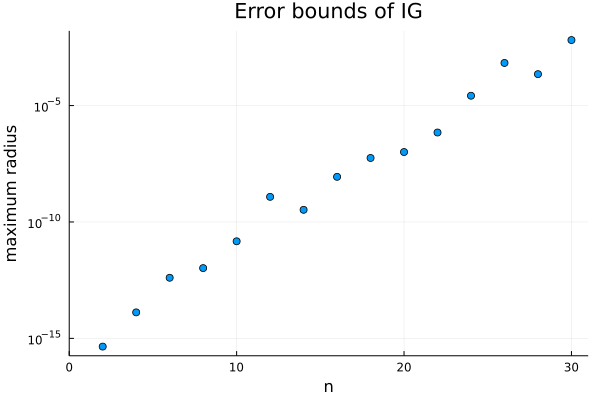

In [31]:
using Plots
index = 2:2:30
max_rad = zeros(size(index))
i = 1;
for n ∈ index
    A = randn(n,n)
    b = A*ones(n)

    A = map(interval, A)
    b = map(interval, b)

    x = A\b
    max_rad[i] = maximum(radius,x);
    i += 1;
end
plot(index, max_rad, yscale=:log10,
    xlabel       ="n",                #X軸のラベル
    ylabel       ="maximum radius",   #Y軸のラベル
    xlims        =(0,31),             #X軸の範囲
    title="Error bounds of IG",       #タイトル
    linewidth    =2,                  #線幅
    seriestype = :scatter,            #点プロットに　
    # size         =(400,300),          #プロットのサイズ
    label = "without pre-conditioned",#凡例のラベル
    legend = false,                   #凡例は今回は消す
)

区間ガウスの消去法（IG）の名誉挽回のために、もしも $R\approx A^{-1}$ なる前処理行列を方程式の右から区間行列積でかけた方程式

$$
    RAx = Rb
$$

にIGを行うと、上のような区間幅の増大は起こらない。しかし、IGの計算コストに加えて、$R$ を計算するコストが必要で計算時間がかかる。

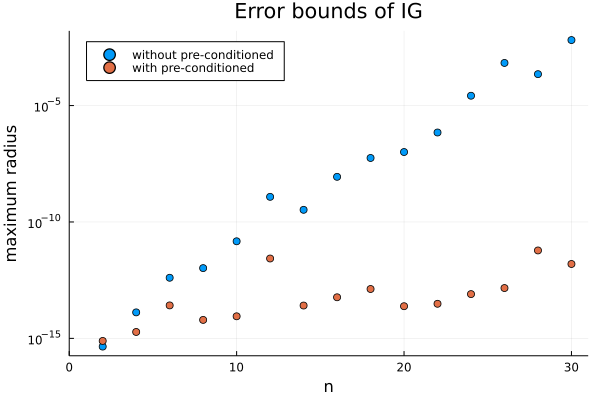

In [32]:
using IntervalMatrices
function int_Gauss(A, b)
    R = IntervalMatrix(map(Interval,inv(A)))
    A = map(Interval,R*IntervalMatrix(map(interval, A)))
    b = map(Interval,R*IntervalBox(map(Interval, b)))
    return A\b
end

i = 1;
for n ∈ index
    A = randn(n,n)
    b = A*ones(n)

    x = int_Gauss(A,b)
    
    max_rad[i] = maximum(radius,x);
    global i += 1;
end
plot!(index, max_rad, yscale=:log10,
    xlabel       ="n",                #X軸のラベル
    ylabel       ="maximum radius",   #Y軸のラベル
    xlims        =(0,31),             #X軸の範囲
    title="Error bounds of IG",       #タイトル
    linewidth    =2,                  #線幅
    seriestype = :scatter,            #点プロットに　
    # size         =(400,300),          #プロットのサイズ
    label = "with pre-conditioned",   #凡例のラベル
    legend = :topleft,                #凡例
)

## 事後評価を用いる高速精度保証付き数値計算法

区間行列積が高速にできるのであれば、区間ガウスの消去法とは違って、次数 $n$ が数千以上のような比較的大規模な行列 にも精度保証が高速で成功する。

### ノルム評価

次の定理を使用する。

**定理 1**　行列 $A\in\mathbb{R}^{n\times n}$, $b\in\mathbb{R}^{n}$ に対して、線型方程式 $Ax=b$ の近似解を $\bar{x}$ とする。いま行列 $R\in\mathbb{R}^{n\times n}\approx A^{-1}$が、

$$
\|I-RA\|<1
$$

をみたすとき、

$$
\left\|A^{-1}b-\bar{x}\right\|\le\frac{\|R(b-A \bar{x})\|}{1-\|I-R A\|}
$$

が成り立つ。ただし、$I$ は $n$ 次単位行列とする。


**証明**
$$
\|A^{-1}b - \bar{x}\|=\|(I-(I-RA))^{-1}R(b-A\bar{x})\|\le \frac{\|R(b-A\bar{x})\|}{1-\|I-RA\|}.
$$

ここで、最後の不等式は $\|T\|<1$ となる行列 $T$ に対して、$\|(I-T)^{-1}\|\le 1/(1-\|T\|)$ となる事実（ノイマン級数の上からの評価、$T:=I-RA$）を使っている。$\Box$

In [33]:
include("IntervalFunctions.jl")
n = 1000
A = randn(n,n)
b = A*ones(n)
@time verifylss_naive(A,b)
@time x = verifylss_naive(A,b)
maximum(radius,x)

  2.151976 seconds (4.15 M allocations: 472.769 MiB, 2.29% gc time, 62.74% compilation time)
  0.843475 seconds (92 allocations: 252.361 MiB, 1.68% gc time)


6.987724843199317e-9

### 成分毎評価

ノルム評価の実装は若干過大評価が入るので、成分毎評価を利用する。

**定理 2（山本の定理）** $A$, $R\in\mathbb{R}^{n\times n}$, $b$, $\bar{x}\in\mathbb{R}^n$, $G:=I-RA$ とする。このとき、$\|G\|_{\infty}<1$ ならば、行列 $A$ は正則であり、次の評価が成り立つ。

$$
|A^{-1}b-\bar{x}|\le |R(b-A\bar{x})| + \frac{\|R(b-A\bar{x})\|_{\infty}}{1-\|G\|_{\infty}}|G|e_n,
$$

ここで、$e_n = (1,1,\dots,1)\in\mathbb{R}^n$で、行列・ベクトルの絶対値は成分毎に絶対値を取るものとし、不等式は成分毎に不等式が成立しているものとする。

**証明** $A^{-1}=(RA)^{-1}R$ ($R$ は正則行列)であり、$\|G\|_{\infty}<1$ より、

$$
(RA)^{-1}=(I-G)^{-1} = I + G + G^2 + \dots = I + G(I-G)^{-1}
$$

となる。任意の $v\in\mathbb{R}^n$ に対して、$|v|\le\|v\|_{\infty} e_n$ であることに注意すると、

\begin{align}
|A^{-1}b-\bar{x}| &= |(RA)^{-1}R(b-A\bar{x})|\\
&= |(I+G(I-G)^{-1})R(b-A\bar{x})|\\
&\le |R(b-A\bar{x})|+|G||(I-G)^{-1}R(b-A\bar{x})|\\
&\le |R(b-A\bar{x})|+\|(I-G)^{-1}\|_{\infty}\|R(b-A\bar{x})\|_{\infty}|G|e_n
\end{align}

となり、$\|(I-G)^{-1}\|_{\infty}\le 1/(1-\|G\|_{\infty})$ を用いると上記の評価式を得る。$\Box$

In [34]:
# include("IntervalFunctions.jl")
@time verifylss(A,b)
@time x = verifylss(A,b)
mean(radius,x)

  1.386598 seconds (1.84 M allocations: 371.762 MiB, 9.49% gc time, 37.18% compilation time)
  1.093210 seconds (105 allocations: 267.690 MiB, 15.27% gc time)


1.687962922103381e-9

In [35]:
@time x₁ = verifylss_naive(A,b);
@show mean(radius,x₁);
@time x₂ = verifylss(A,b);
@show mean(radius,x₂);

  0.571001 seconds (92 allocations: 252.361 MiB, 1.75% gc time)
mean(radius, x₁) = 6.987724816776009e-9
  0.708592 seconds (105 allocations: 267.690 MiB, 0.74% gc time)
mean(radius, x₂) = 1.687962922103381e-9


## IntervalLinerAlgebra.jl

最近、[IntervalLinearAlgebra.jl](https://github.com/JuliaIntervals/IntervalLinearAlgebra.jl)というパッケージがあることを知った。これを使うと区間線形方程式を求解できる。中身は前処理付き区間ガウスの消去法。

In [36]:
using IntervalLinearAlgebra

n = 500
A = randn(n,n)
b = A*ones(n)

iA = map(interval, A)
ib = map(interval, b)

@time x = solve(iA, ib)
@show maximum(radius,x)

@time x = int_Gauss(A, b)
@show maximum(radius,x)

  4.224162 seconds (2.77 M allocations: 185.068 MiB, 0.41% gc time, 16.09% compilation time)
maximum(radius, x) = 4.658686769687392e-10
  4.800298 seconds (3.81 M allocations: 221.607 MiB, 0.43% gc time, 25.90% compilation time)
maximum(radius, x) = 4.65941840666062e-10


4.65941840666062e-10

上で紹介した事後評価を用いる精度保証方法は格段に速い（少しだけ過大評価がある）。

In [37]:
@time x = verifylss(A, b)
@show maximum(radius,x);

  0.232293 seconds (105 allocations: 67.090 MiB, 6.10% gc time)
maximum(radius, x) = 9.823210023185425e-10


IntervalLinearAlgebra.jlには他の解法も実装されているらしい（未確認）、実行してみると。

In [38]:
@time x = solve(iA, ib, HansenBliekRohn())
@show maximum(radius,x)
@time x = solve(iA, ib, LinearKrawczyk())
@show maximum(radius,x)
@time x = solve(iA, ib, Jacobi())
@show maximum(radius,x)
@time x = solve(iA, ib, GaussSeidel())
@show maximum(radius,x);

  2.273032 seconds (8.88 M allocations: 669.300 MiB, 3.66% gc time, 85.56% compilation time)
maximum(radius, x) = 6.961496934465572e-10
  1.068981 seconds (2.55 M allocations: 236.377 MiB, 1.85% gc time, 70.60% compilation time)
maximum(radius, x) = 1.0000000007300376
  0.462733 seconds (830.33 k allocations: 113.196 MiB, 4.43% gc time, 46.76% compilation time)
maximum(radius, x) = 4.659322927480503e-10
  0.412819 seconds (573.49 k allocations: 98.303 MiB, 1.55% gc time, 43.69% compilation time)
maximum(radius, x) = 4.659322927480503e-10


---

# まとめ

- 計算機言語Juliaを用いた精度保証付き数値計算の実装例（区間演算、ドット積・行列ベクトル積・行列積）を紹介
- オープンソースのコミュニティは皆が参画しやすく開発が早い。一方で、実装が正しいかどうかを自分で検証・判断する必要あり
- 世界中の開発者が作ったパッケージを組み合わせて、多倍長浮動小数点数の区間演算などが割と手軽に何でもできるのは面白い
- 個人的には、学生さんの数値計算環境におすすめ（正しさの検証は必須）

## 現時点のベクトプラクティス

- 内積・行列ベクトル積：IntervalArithmetic.jlの実装を使う
- 区間行列積：IntervalMatrices.jlを使う
- 線形方程式：事後評価の方法（`verifylss`）を使う

<center>

### ご清聴ありがとうございました。

</center>